In [13]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# 1. Load data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
test_ids_all = df_test["PassengerId"].copy()  # 원본 PassengerId 저장


# 데이터 결측치 처리
def fill_na_test(df, train_ref):
    # Embarked: train의 최빈값
    most_common_emb = train_ref["Embarked"].mode()[0]
    df["Embarked"] = df["Embarked"].fillna(most_common_emb)
    # Fare: train의 중앙값
    median_fare = train_ref["Fare"].median()
    df["Fare"] = df["Fare"].fillna(median_fare)
    # Age: train의 중앙값
    median_age = train_ref["Age"].median()
    df["Age"] = df["Age"].fillna(median_age)
    return df


# 결측 행 채워넣기
df_test = fill_na_test(df_test, train_ref=df_train)
df_train = fill_na_test(df_train, train_ref=df_train)


# 2. 간단한 특징 추출 (Title, FamilySize, IsAlone)
def simple_features(df):
    # Title
    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    df["Title"] = df["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    # Family
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["IsWoman"] = (df["Sex"] == "female").astype(int)
    df["IsChild"] = (df["Age"] < 16).astype(int)
    df["IsFirstClass"] = (df["Pclass"] == 1).astype(int)
    df["IsPrivileged"] = (
        (df["IsWoman"] + df["IsChild"] + df["IsFirstClass"]) > 0
    ).astype(int)
    return df


df_train = simple_features(df_train)
df_test = simple_features(df_test)

# 3. 결측치 기준에 따라 컬럼/행 제거
#    - Cabin, Name, Ticket, PassengerId는 모델에 안 쓸 거라 통째로 버림
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
df_train.drop(columns=drop_cols, inplace=True)
df_test.drop(columns=drop_cols, inplace=True)

# 4. 범주형 인코딩
cat_cols = ["Sex", "Embarked", "Title"]
for col in cat_cols:
    le = LabelEncoder()
    vals = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(vals)
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# 5. 수치형 스케일링
num_cols = ["Age", "Fare", "FamilySize"]
scaler = StandardScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

# 6. 학습/테스트 셋 분리
features = [
    "Pclass",
    "Sex",
    "Age",
    "Fare",
    "FamilySize",
    "IsAlone",
    "Embarked",
    "Title",
    "IsPrivileged",
]
X_train = df_train[features]
y_train = df_train["Survived"]
X_test = df_test[features]

In [14]:
# 7. 스태킹 앙상블 정의 (이전과 동일)
lgbm = lgb.LGBMClassifier(verbosity=-1, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
svc = SVC(probability=True, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)

stack = StackingClassifier(
    estimators=[
        ("lgbm", lgbm),
        ("xgb", xgb),
        ("svc", svc),
        ("etc", etc),
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1,
)

# 8. GridSearchCV로 XGB와 final_estimator(C)만 탐색
param_grid = {
    # XGBoost 파라미터
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    # 메타 모델(LogisticRegression) C 값
    "final_estimator__C": [0.1, 1, 10],
}

search = GridSearchCV(
    stack,
    param_grid=param_grid,
    scoring="accuracy",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
)
search.fit(X_train, y_train)

best_idx = search.best_index_

print("Best Params:", search.best_params_)
print("CV Accuracy:", round(search.best_score_, 4))

# 9. 예측 및 저장
best_model = search.best_estimator_
preds = best_model.predict(X_test)

output = pd.DataFrame(
    {
        "PassengerId": test_ids_all,
        "Survived": preds,
    }
)
output.to_csv("submission_grid_xgb_lr.csv", index=False)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'final_estimator__C': 1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5}
CV Accuracy: 0.853


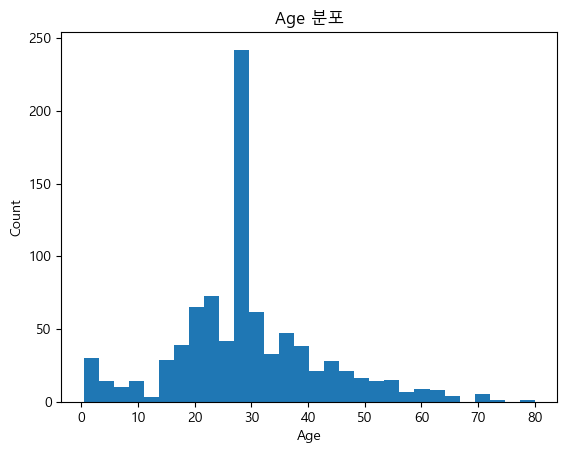

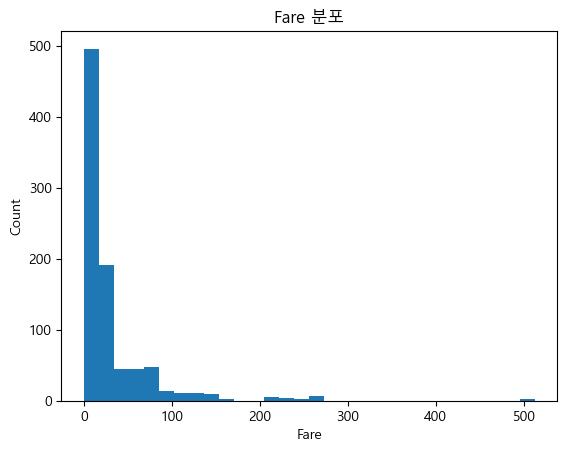

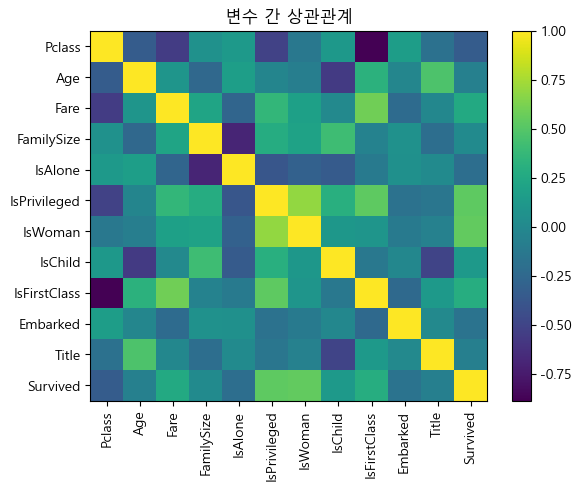

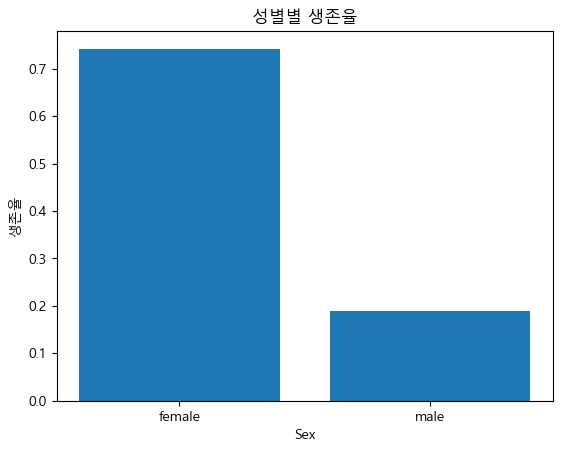

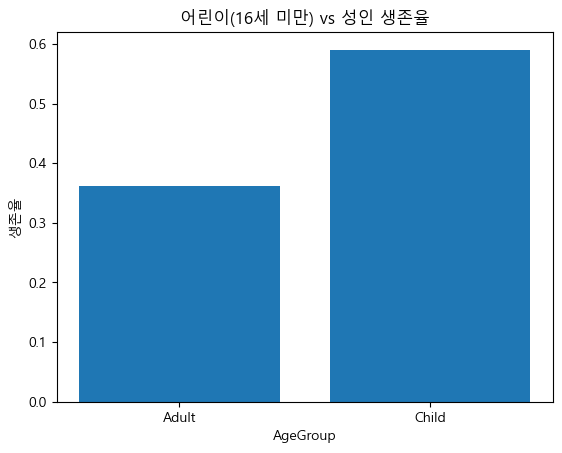

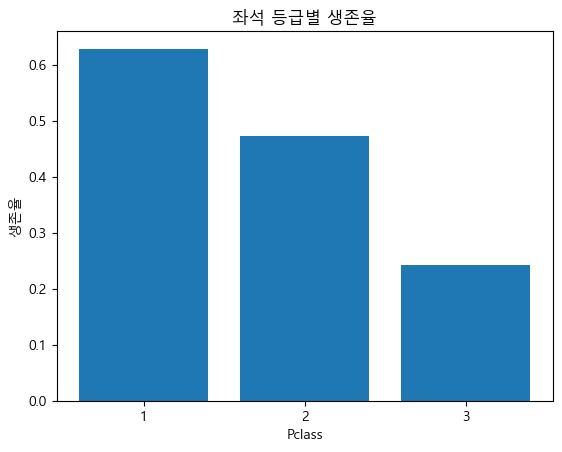

In [ ]:
plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False



# 1) 데이터 로드 및 간단 전처리


df = pd.read_csv("train.csv")

df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())


def simple_features(df):

    # Title

    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

    df["Title"] = df["Title"].replace(
        [

            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",

            "Jonkheer",
            "Dona",
        ],

        "Rare",
    )


    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})


    # Family / Alone / Woman / Child / FirstClass / Privileged

    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    df["IsWoman"] = (df["Sex"] == "female").astype(int)

    df["IsChild"] = (df["Age"] < 16).astype(int)

    df["IsFirstClass"] = (df["Pclass"] == 1).astype(int)

    df["IsPrivileged"] = (
        (df["IsWoman"] + df["IsChild"] + df["IsFirstClass"]) > 0
    ).astype(int)
    return df



df = simple_features(df)



# 범주형 인코딩 (상관관계 분석용)


le = LabelEncoder()


df["Embarked"] = le.fit_transform(df["Embarked"])


df["Title"] = le.fit_transform(df["Title"])



# 2) 주요 변수 분포 시각화 (히스토그램)


numeric_cols = ["Age", "Fare"]


for col in numeric_cols:

    plt.figure()

    plt.hist(df[col], bins=30)

    plt.title(f"{col} 분포")

    plt.xlabel(col)

    plt.ylabel("Count")



# 3) 변수 간 상관관계 히트맵


features_corr = [
    "Pclass",
    "Age",
    "Fare",
    "FamilySize",
    "IsAlone",
    "IsPrivileged",
    "IsWoman",
    "IsChild",
    "IsFirstClass",
    "Embarked",
    "Title",
    "Survived",
]



corr = df[features_corr].corr()


plt.figure()


plt.imshow(corr, aspect="auto", interpolation="nearest")



plt.xticks(range(len(corr)), corr.columns, rotation=90)


plt.yticks(range(len(corr)), corr.index)


plt.colorbar()



plt.title("변수 간 상관관계")



# 4) 주요 발견 사항 시각화


#   4-1) 성별별 생존율


surv_sex = df.groupby("Sex")["Survived"].mean()


plt.figure()


plt.bar(surv_sex.index, surv_sex.values)


plt.title("성별별 생존율")


plt.xlabel("Sex")


plt.ylabel("생존율")


#   4-2) 어린이 vs 성인 생존율


df["AgeGroup"] = np.where(df["Age"] < 16, "Child", "Adult")


surv_age = df.groupby("AgeGroup")["Survived"].mean()


plt.figure()


plt.bar(surv_age.index, surv_age.values)


plt.title("어린이(16세 미만) vs 성인 생존율")


plt.xlabel("AgeGroup")


plt.ylabel("생존율")


#   4-3) Pclass별 생존율


surv_pclass = df.groupby("Pclass")["Survived"].mean()


plt.figure()


plt.bar(surv_pclass.index.astype(str), surv_pclass.values)


plt.title("좌석 등급별 생존율")


plt.xlabel("Pclass")


plt.ylabel("생존율")


plt.show()